In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from tqdm import tqdm
import re

from collections import Counter
from collections import defaultdict

from catboost import CatBoostRegressor, Pool
from scipy.stats import normaltest

import optuna
from optuna.samplers import TPESampler


from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train_result = pd.read_csv('data/df_train_result_from_eda_2.csv')

In [3]:

def safe_literal_eval(x):
    if isinstance(x, list):
        return x 
    elif isinstance(x, str):
        try:
            return literal_eval(x)
        except:
            return np.nan
    else:
        return np.nan


In [4]:
df_train_result['clustered_skills'] = df_train_result['clustered_skills'].apply(safe_literal_eval)


In [5]:
df_train_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17398 entries, 0 to 17397
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       17398 non-null  int64  
 1   salary from                      17398 non-null  float64
 2   salary to                        17398 non-null  float64
 3   position                         17398 non-null  object 
 4   experience                       17398 non-null  object 
 5   skills                           17398 non-null  object 
 6   schedule                         17398 non-null  object 
 7   employment                       17398 non-null  object 
 8   vacancy                          17398 non-null  object 
 9   level                            17398 non-null  object 
 10  region                           17398 non-null  object 
 11  mapped_skills                    17398 non-null  object 
 12  anchors_list      

In [ ]:

def filtered_skills_top_n(df_train_result, n):
    """
    Фильтрует навыки, оставляя только N наиболее популярных навыков для каждой позиции.
    
    :param df_skills_filtered: Входящий DataFrame с колонками 'position' и 'skills'.
    :param n: Число наиболее популярных навыков, которое нужно оставить.
    :return: Отфильтрованный DataFrame с сокращённым списком навыков.
    """
    
    result_df = df_train_result.copy()
    #display(result_df['skills'])
    # Перебираем каждую уникальную должность
    for pos in result_df['position'].unique():
        # Маска для выбора строк с нужной должностью
        mask = result_df['position'] == pos
        
        # Собираем все навыки в один большой список
        skills_lists = result_df.loc[mask, 'clustered_skills']
        all_skills = [skill for sublist in skills_lists for skill in sublist]
        
        # Считаем частоту появления каждого навыка
        skill_counts = Counter(all_skills)
        
        # Берём топ-n навыков
        top_n_skills = set([skill for skill, _ in skill_counts.most_common(n)])
        
        # Применяем фильтр к списку навыков
        result_df.loc[mask, 'clustered_skills'] = skills_lists.apply(
            lambda skill_list: [s for s in skill_list if s in top_n_skills]
        )
        #display(result_df['skills'])
    return result_df
from scipy.stats import normaltest



In [9]:
# Функция очистки и нормализации
def process_series(series, colname, position):
    series = pd.to_numeric(series, errors='coerce')
    series = series.dropna()
    n_total = len(series)


    stat, p = normaltest(series)
    is_normal = p > 0.05

    if is_normal:
        mu, sigma = series.mean(), series.std()
        mask = (series >= mu - 3 * sigma) & (series <= mu + 3 * sigma)
    else:
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        mask = (series >= q1 - 1.5 * iqr) & (series <= q3 + 1.5 * iqr)

    n_filtered = mask.sum()
    n_removed = n_total - n_filtered


    return series[mask]

Top-N Skills:   0%|          | 0/4 [00:00<?, ?it/s]

' Взяли 30 скилов . Осталось 16881 cтрок в df. Всего уникальных 704'

0:	learn: 41019.8152478	test: 39412.3777049	best: 39412.3777049 (0)	total: 34.7ms	remaining: 34.7s
100:	learn: 21365.9230749	test: 21909.1943677	best: 21909.1943677 (100)	total: 3.13s	remaining: 27.9s
200:	learn: 20783.9926448	test: 21811.2215210	best: 21811.2215210 (200)	total: 5.58s	remaining: 22.2s
300:	learn: 20380.5416013	test: 21722.6656141	best: 21721.8763579 (298)	total: 7.99s	remaining: 18.6s
400:	learn: 20122.0941840	test: 21678.9523654	best: 21676.1172975 (391)	total: 10.5s	remaining: 15.7s
500:	learn: 19896.6368899	test: 21658.6562350	best: 21652.4903330 (467)	total: 12.9s	remaining: 12.8s
600:	learn: 19681.0750438	test: 21617.1441761	best: 21609.8595906 (588)	total: 15.4s	remaining: 10.2s
700:	learn: 19461.3595686	test: 21578.9171183	best: 21576.8522819 (687)	total: 17.9s	remaining: 7.62s
800:	learn: 19331.1331265	test: 21580.8712423	best: 21575.2871036 (725)	total: 20.3s	remaining: 5.04s
900:	learn: 19140.7817782	test: 21557.4132702	best: 21555.6237889 (887)	total: 22.9s	

Top-N Skills:  25%|██▌       | 1/4 [01:43<05:11, 103.71s/it]

' Взяли 50 скилов . Осталось 17189 cтрок в df. Всего уникальных 1048'

0:	learn: 40712.2494141	test: 40080.9401725	best: 40080.9401725 (0)	total: 33ms	remaining: 33s
100:	learn: 21145.7540264	test: 21862.8954267	best: 21862.8954267 (100)	total: 2.98s	remaining: 26.6s
200:	learn: 20454.2071483	test: 21584.1204499	best: 21581.8319360 (199)	total: 5.26s	remaining: 20.9s
300:	learn: 20078.1954021	test: 21455.8588782	best: 21453.0946090 (298)	total: 7.54s	remaining: 17.5s
400:	learn: 19937.3658741	test: 21434.7311725	best: 21428.6940716 (352)	total: 9.64s	remaining: 14.4s
500:	learn: 19725.1104139	test: 21415.2454107	best: 21413.4387585 (452)	total: 11.9s	remaining: 11.8s
600:	learn: 19598.9184716	test: 21390.6391779	best: 21389.5602337 (599)	total: 13.9s	remaining: 9.21s
700:	learn: 19430.2909469	test: 21361.1977129	best: 21358.7265790 (666)	total: 16.1s	remaining: 6.87s
800:	learn: 19304.6244807	test: 21350.2321417	best: 21348.7319664 (794)	total: 18.2s	remaining: 4.53s
900:	learn: 19099.1485472	test: 21337.8890374	best: 21324.0974069 (844)	total: 20.5s	rema

Top-N Skills:  50%|█████     | 2/4 [03:21<03:20, 100.49s/it]

' Взяли 70 скилов . Осталось 17296 cтрок в df. Всего уникальных 1277'

0:	learn: 40643.0419938	test: 39981.3959347	best: 39981.3959347 (0)	total: 29ms	remaining: 29s
100:	learn: 21502.3373806	test: 22064.3579061	best: 22064.1015833 (99)	total: 2.71s	remaining: 24.1s
200:	learn: 20781.7749822	test: 21675.2614377	best: 21673.1154410 (199)	total: 4.91s	remaining: 19.5s
300:	learn: 20424.6343197	test: 21623.5782670	best: 21614.2874180 (286)	total: 7.03s	remaining: 16.3s
400:	learn: 20202.1754281	test: 21638.6428364	best: 21614.2874180 (286)	total: 9.08s	remaining: 13.6s
500:	learn: 19987.7598161	test: 21612.0766859	best: 21611.2035906 (495)	total: 11.1s	remaining: 11.1s
600:	learn: 19852.9988443	test: 21593.4953789	best: 21590.8078504 (588)	total: 13.1s	remaining: 8.71s
700:	learn: 19611.6249143	test: 21529.5373369	best: 21521.9562409 (671)	total: 15.2s	remaining: 6.5s
800:	learn: 19391.0340068	test: 21484.5690254	best: 21476.2043910 (779)	total: 17.5s	remaining: 4.35s
900:	learn: 19138.7812305	test: 21420.0089151	best: 21420.0089151 (900)	total: 19.8s	remain

Top-N Skills:  75%|███████▌  | 3/4 [05:00<01:39, 99.41s/it] 

' Взяли 100 скилов . Осталось 17349 cтрок в df. Всего уникальных 1539'

0:	learn: 40716.8447931	test: 39398.1167052	best: 39398.1167052 (0)	total: 70.9ms	remaining: 1m 10s
100:	learn: 21245.0558025	test: 22282.4547460	best: 22282.4547460 (100)	total: 3.08s	remaining: 27.4s
200:	learn: 20563.4358980	test: 22107.7689843	best: 22106.3014552 (196)	total: 5.41s	remaining: 21.5s
300:	learn: 20159.8100011	test: 22051.1578528	best: 22048.1398415 (296)	total: 7.68s	remaining: 17.8s
400:	learn: 19843.7563727	test: 21976.1480337	best: 21974.2097116 (397)	total: 10s	remaining: 15s
500:	learn: 19570.0213190	test: 21915.6655166	best: 21913.3023076 (495)	total: 12.2s	remaining: 12.2s
600:	learn: 19419.3144556	test: 21899.4671484	best: 21893.2997428 (584)	total: 14.3s	remaining: 9.5s
700:	learn: 19305.3422571	test: 21869.8175226	best: 21867.9723340 (676)	total: 16.4s	remaining: 6.99s
800:	learn: 19242.8527083	test: 21851.7628992	best: 21851.7628992 (800)	total: 18.6s	remaining: 4.62s
900:	learn: 19163.8421039	test: 21842.4548783	best: 21842.3600380 (898)	total: 20.6s	rema

Top-N Skills: 100%|██████████| 4/4 [06:38<00:00, 99.50s/it]


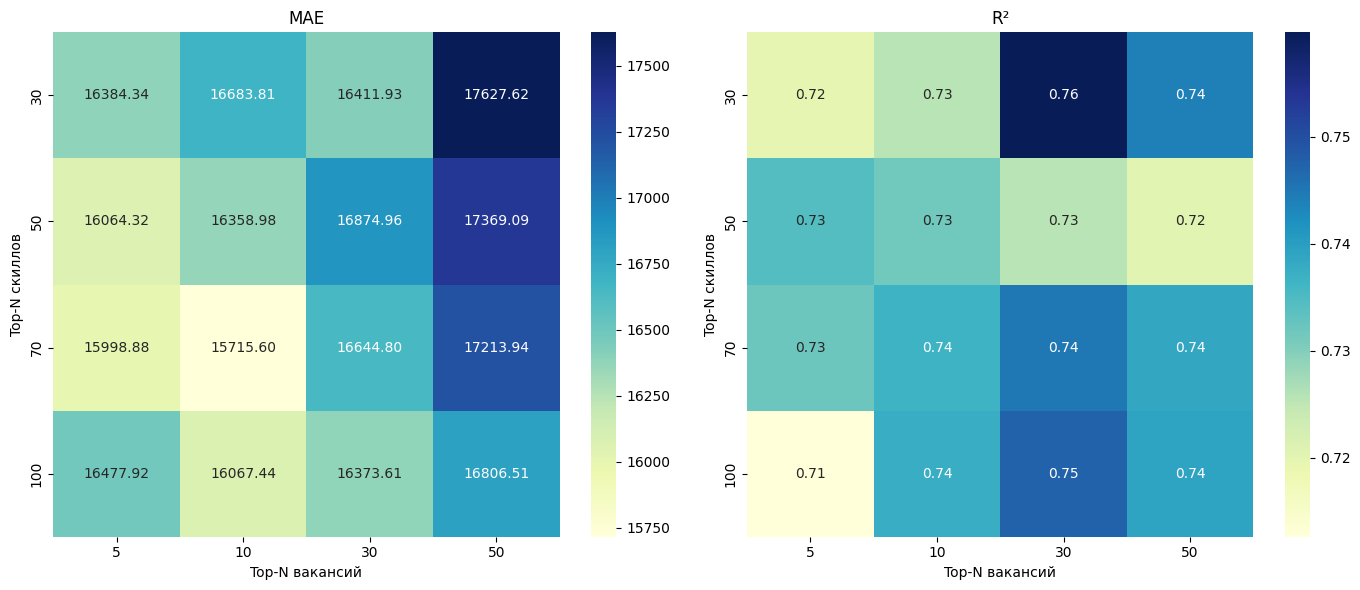

Лучшее сочетание по MAE:
Top Skills: 70.0, Top Vacancies: 10.0, MAE: 15715.60, R²: 0.74


In [21]:

import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message='DataFrameGroupBy.apply operated on the grouping columns.')

# Параметры
top_skills_range = [ 30, 50, 70, 100]
top_vacancies_range = [5,10, 30, 50] 
# Список позиций, которые оставляем

allowed_positions2 = [
    "Аналитик",
    "Бизнес-аналитик",
    "Дата-сайентист",
    "Дизайнер, художник",
    "Программист, разработчик",
    "Продуктовый аналитик",
    "Руководитель проектов",
    "Сетевой инженер",
    "Системный администратор",
    "Системный аналитик",
    "Специалист по информационной безопасности",
    "Специалист технической поддержки",
    "Технический писатель",
    'Тестировщик',
    'Менеджер продукта',
    'Системный инженер',
    'BI-аналитик, аналитик данных',
    'Методолог',
    'Руководитель группы разработки'

]




allowed_positions = [
    "Аналитик",
    "Бизнес-аналитик",
    #"Дата-сайентист",
    "Дизайнер, художник",
    #"Программист, разработчик",
    "Продуктовый аналитик",
    "Руководитель проектов",
    "Сетевой инженер",
    "Системный администратор",
    #"Системный аналитик",
    "Специалист по информационной безопасности",
    "Специалист технической поддержки",
    "Технический писатель"
]

results = []

for skill_n in tqdm(top_skills_range, desc="Top-N Skills"):
    df_skills_filtered = filtered_skills_top_n(df_train_result.copy(), skill_n)
    #display(df_skills_filtered['skills'])
    # Удаляем строки с пустыми списками skills
    df_skills_filtered = df_skills_filtered[df_skills_filtered['clustered_skills'].apply(lambda x: len(x) > 0)]
    

    def flatten_skills(skills_series):
        all_skills = []
        for skill_list in skills_series:
            if isinstance(skill_list, list):
                all_skills.extend(skill_list)
        return all_skills
    #display(df_skills_filtered['skills'])
    display(f" Взяли {skill_n} скилов . Осталось {df_skills_filtered.shape[0]} cтрок в df. Всего уникальных {len(set(flatten_skills(df_skills_filtered['clustered_skills'])))}" )
    for vac_n in top_vacancies_range:
        # Фильтрация вакансий по top-N внутри позиции
        def filter_top_vacancies(group, n=vac_n):
            vac_counts = group['vacancy_clustered'].value_counts()
            top_vacancies = vac_counts.head(n).index.tolist()
            #top_vacancies = vac_counts.index.tolist()
            return group[group['vacancy_clustered'].isin(top_vacancies)]
        


        df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)
        df_filtered = df_filtered[df_filtered['position'].isin(allowed_positions)]

        
        
        
        # Обработка целевой переменной и признаков
        df_temp = df_filtered.copy()
        
        
        # Очистка целевой переменной от выбросов
        positions_temp = df_temp['position'].dropna().unique()

        for pos in positions_temp:
            pos_mask = df_temp['position'] == pos
            clean_series = process_series(df_temp.loc[pos_mask, 'salary from'], 'salary from', pos)
            if clean_series is not None:
                df_temp.loc[clean_series.index, 'salary from norm'] = clean_series

        # Удалим строки с NaN после очистки
        df_temp = df_temp.dropna(subset=['salary from norm'])
        
        
        if df_temp.empty:
            continue



        # 1. Подготовка данных
        y = df_temp['salary from norm']

        if df_temp.empty:
            continue
        # Определяем порядковое кодирование для experience и level
        experience_order = {
            'Нет опыта': 0,
            '1–3 года': 1,
            '3–6 лет': 2,
            'Более 6 лет': 3,
            'Unknown': -1  # или np.nan для пропусков
        }

        level_order = {
            'Trainee': 0,
            'Junior': 1,
            'Middle': 2,
            'Senior': 3,
            'Lead': 4,
            'Chief': 5,
            'Unknown': -1  # или np.nan для пропусков
        }
        
        # Применяем порядковое кодирование
        df_temp['experience_ord'] = df_temp['experience'].map(experience_order) #.astype(str)
        df_temp['level_ord'] = df_temp['level'].map(level_order) #.astype(str)
        
        
        
        # Преобразование skills в строки с явным указанием типа
        df_temp['skills_str'] = df_temp['clustered_skills'].apply(
            lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x)
        )

        # 2. Формирование признаков
        features = ['position', 'experience_ord', 'schedule', 'employment', 'level_ord', 'vacancy_clustered', 'skills_str', 'region']
        X = df_temp[features]

        # 3. Указываем типы признаков
        cat_features = ['position', 'experience_ord', 'schedule', 'employment', 'level_ord', 'vacancy_clustered', 'region']
        text_features = ['skills_str']

        # 4. Разбиение на train/test
        try:
            splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            for train_idx, test_idx in splitter.split(X, df_temp['position']):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                # 5. Создаем Pool с минимальными параметрами
                train_pool = Pool(
                    data=X_train,
                    label=y_train,
                    cat_features=cat_features,
                    text_features=text_features
                )
                
                test_pool = Pool(
                    data=X_test,
                    label=y_test,
                    cat_features=cat_features,
                    text_features=text_features
                )

        except ValueError as e:
            print(f"Ошибка split при skill_n={skill_n}, vac_n={vac_n}: {e}")
            continue

        # 6. Упрощенная модель без сложной обработки текста
        model = CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=6,
            task_type='GPU',
            verbose=100
        )

        # 7. Обучение с базовыми параметрами
        model.fit(train_pool, eval_set=test_pool)

        y_pred = model.predict(X_test)
        
        
        #y_pred = np.expm1(y_pred)
        
        #mae = mean_absolute_error(np.expm1(y_test), y_pred)
        #r2 = r2_score(np.expm1(y_test),  y_pred)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test,  y_pred)

        results.append({
            'top_skills': skill_n,
            'top_vacancies': vac_n,
            'mae': mae,
            'r2': r2,
            'rows': len(df_temp)
        })

# Переводим результаты в DataFrame
results_df = pd.DataFrame(results)

# Визуализация результатов
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pivot_mae = results_df.pivot(index='top_skills', columns='top_vacancies', values='mae')
sns.heatmap(pivot_mae, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('MAE')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.subplot(1, 2, 2)
pivot_r2 = results_df.pivot(index='top_skills', columns='top_vacancies', values='r2')
sns.heatmap(pivot_r2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('R²')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.tight_layout()
plt.show()

# Вывод лучшего сочетания
best_row = results_df.sort_values(by='mae').iloc[0]
print(f"Лучшее сочетание по MAE:\nTop Skills: {best_row['top_skills']}, "
      f"Top Vacancies: {best_row['top_vacancies']}, "
      f"MAE: {best_row['mae']:.2f}, R²: {best_row['r2']:.2f}")





Лучшее сочетание по MAE:
Top Skills: 30.0, Top Vacancies: 30.0, MAE: 16016.85, R²: 0.76

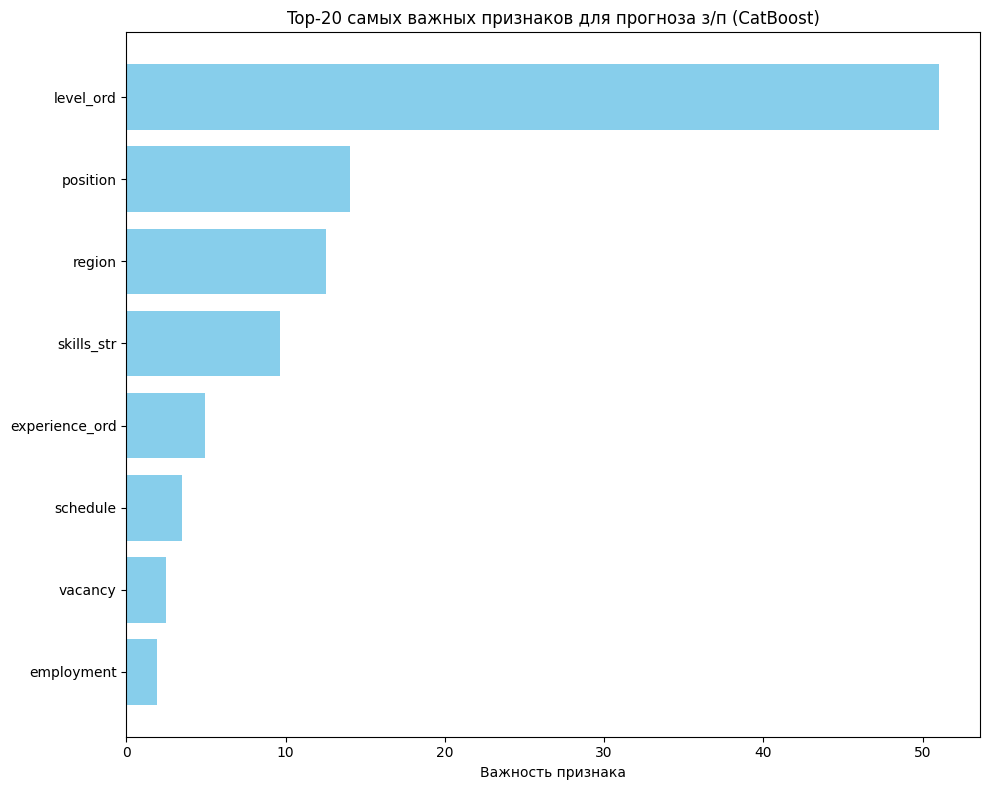

In [20]:
# Получаем важность признаков
feature_importance = model.get_feature_importance()
# Сортируем и получаем топ-20
indices = np.argsort(feature_importance)[::-1][:20]
names = [features[i] for i in indices]
scores = [feature_importance[i] for i in indices]

# Создаем горизонтальный bar plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(names)), scores, align='center', color='skyblue')
plt.yticks(range(len(names)), names)
plt.xlabel('Важность признака')
plt.title('Top-20 самых важных признаков для прогноза з/п (CatBoost)')
# Важный момент: инвертируем ось Y, чтобы самый важный признак был сверху
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# пробуем оптимизировать гиперпараметры

import optuna
from optuna.samplers import TPESampler
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Фиксируем параметры
top_skills = 30
top_vacancies = 10000

# Список позиций, которые оставляем
allowed_positions = [
    "Аналитик",
    "Бизнес-аналитик",
    "Дизайнер, художник",
    "Продуктовый аналитик",
    "Руководитель проектов",
    "Сетевой инженер",
    "Системный администратор",
    "Специалист по информационной безопасности",
    "Специалист технической поддержки",
    "Технический писатель"
]
allowed_positions2 = [
    "Аналитик",
    "Бизнес-аналитик",
    "Дата-сайентист",
    "Дизайнер, художник",
    "Программист, разработчик",
    "Продуктовый аналитик",
    "Руководитель проектов",
    "Сетевой инженер",
    "Системный администратор",
    "Системный аналитик",
    "Специалист по информационной безопасности",
    "Специалист технической поддержки",
    "Технический писатель",
    'Тестировщик',
    'Менеджер продукта',
    'Системный инженер',
    'BI-аналитик, аналитик данных',
    'Методолог',
    'Руководитель группы разработки'

]

# Функция для подготовки данных
def prepare_data(df_train_result, top_skills, top_vacancies):
    # Фильтрация по топ-N скилов
    df_skills_filtered = filtered_skills_top_n(df_train_result.copy(), top_skills)
    df_skills_filtered = df_skills_filtered[df_skills_filtered['mapped_skills'].apply(lambda x: len(x) > 0)]
    
    # Фильтрация по топ-N вакансий внутри позиции
    def filter_top_vacancies(group, n=top_vacancies):
        vac_counts = group['vacancy_clustered'].value_counts()
        top_vacancies = vac_counts.head(n).index.tolist()
        return group[group['vacancy_clustered'].isin(top_vacancies)]
    
    df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)
    df_filtered = df_filtered[df_filtered['position'].isin(allowed_positions)] # 
    
    # Обработка целевой переменной
    df_temp = df_filtered.copy()
    
    # Очистка целевой переменной от выбросов
    positions_temp = df_temp['position'].dropna().unique()
    for pos in positions_temp:
        pos_mask = df_temp['position'] == pos
        clean_series = process_series(df_temp.loc[pos_mask, 'salary from'], 'salary from', pos)
        if clean_series is not None:
            df_temp.loc[clean_series.index, 'salary from norm'] = clean_series
    
    # Удалим строки с NaN после очистки
    df_temp = df_temp.dropna(subset=['salary from norm'])
    
    if df_temp.empty:
        return None, None, None, None
    
    # Подготовка признаков
    y = df_temp['salary from norm']
    
    # Порядковое кодирование
    experience_order = {
        'Нет опыта': 0,
        '1–3 года': 1,
        '3–6 лет': 2,
        'Более 6 лет': 3,
        'Unknown': -1
    }

    level_order = {
        'Trainee': 0,
        'Junior': 1,
        'Middle': 2,
        'Senior': 3,
        'Lead': 4,
        'Chief': 5,
        'Unknown': -1
    }
    
    df_temp['experience_ord'] = df_temp['experience'].map(experience_order)
    df_temp['level_ord'] = df_temp['level'].map(level_order)
    df_temp['skills_str'] = df_temp['mapped_skills'].apply(
        lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x)
    )
    
    features = ['position', 'experience_ord', 'schedule', 'employment', 'level_ord', 'skills_str', 'region'] # , 'vacancy_clustered'
    X = df_temp[features]
    
    cat_features = ['position', 'experience_ord', 'schedule', 'employment', 'level_ord', 'region'] # , 'vacancy_clustered'
    text_features = ['skills_str']
    
    return X, y, cat_features, text_features

# Функция для создания train/test split
def create_train_test_split(X, y, cat_features, text_features):
    try:
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        for train_idx, test_idx in splitter.split(X, X['position']):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            train_pool = Pool(
                data=X_train,
                label=y_train,
                cat_features=cat_features,
                text_features=text_features
            )
            
            test_pool = Pool(
                data=X_test,
                label=y_test,
                cat_features=cat_features,
                text_features=text_features
            )
            
            return train_pool, test_pool, X_test, y_test
            
    except Exception as e:
        print(f"Ошибка при создании split: {e}")
        return None, None, None, None

# Функция оптимизации Optuna
def objective(trial):
    # Подготовка данных
    X, y, cat_features, text_features = prepare_data(df_train_result.copy(), top_skills, top_vacancies)
    if X is None:
        return float('inf')
    
    # Создание train/test split
    train_pool, test_pool, X_test, y_test = create_train_test_split(X, y, cat_features, text_features)
    if train_pool is None:
        return float('inf')
    
    # Параметры для оптимизации
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'verbose': False
    }
    
    # Обучение модели
    model = CatBoostRegressor(
        task_type='GPU',
        **params
    )
    
    try:
        model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100, verbose=0)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        return mae
    except Exception as e:
        print(f"Ошибка при обучении: {e}")
        return float('inf')

# Основной код оптимизации
print("Подготовка данных...")
X, y, cat_features, text_features = prepare_data(df_train_result.copy(), top_skills, top_vacancies)
print(f"Размер данных после фильтрации: {X.shape if X is not None else 0}")

# Создаем исследование Optuna
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42)
)

print("Запуск оптимизации гиперпараметров...")
study.optimize(objective, n_trials=40, show_progress_bar=True)

# Вывод результатов
print("Лучшие параметры:")
print(study.best_params)
print(f"Лучшее MAE: {study.best_value:.4f}")

# Обучение финальной модели с лучшими параметрами
print("Обучение финальной модели с лучшими параметрами...")

# Подготовка данных для финального обучения
X, y, cat_features, text_features = prepare_data(df_train_result.copy(), top_skills, top_vacancies)
train_pool, test_pool, X_test, y_test = create_train_test_split(X, y, cat_features, text_features)

# Добавляем фиксированные параметры к лучшим
best_params = study.best_params.copy()
best_params['task_type'] = 'GPU'
best_params['verbose'] = 100

final_model = CatBoostRegressor(**best_params)
final_model.fit(train_pool, eval_set=test_pool)

# Предсказание и оценка
y_pred = final_model.predict(X_test)
final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"Финальное MAE: {final_mae:.4f}")
print(f"Финальное R2: {final_r2:.4f}")

# Сохранение модели
final_model.save_model('catboost_optimized_model.cbm')

# Сохранение лучших параметров
best_params_df = pd.DataFrame([study.best_params])
best_params_df.to_csv('best_hyperparameters.csv', index=False)

print("Оптимизация завершена!")

Подготовка данных...


[I 2025-09-07 18:17:10,226] A new study created in memory with name: no-name-46c717ab-4083-42b3-8f25-f51515eaee24


Размер данных после фильтрации: (8653, 7)
Запуск оптимизации гиперпараметров...


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-09-07 18:17:15,421] Trial 0 finished with value: 17054.61365094484 and parameters: {'iterations': 1062, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 6.387926357773329, 'random_strength': 1.6445845403801216, 'bagging_temperature': 0.15599452033620265, 'border_count': 45, 'min_data_in_leaf': 87, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 17054.61365094484.
[I 2025-09-07 18:17:18,865] Trial 1 finished with value: 16994.8721793494 and parameters: {'iterations': 1955, 'learning_rate': 0.16967533607196555, 'depth': 5, 'l2_leaf_reg': 2.636424704863906, 'random_strength': 1.915704647548995, 'bagging_temperature': 0.3042422429595377, 'border_count': 149, 'min_data_in_leaf': 44, 'grow_policy': 'Depthwise'}. Best is trial 1 with value: 16994.8721793494.
[I 2025-09-07 18:17:49,248] Trial 2 finished with value: 16879.161008061797 and parameters: {'iterations': 938, 'learning_rate': 0.03476649150592621, 'depth': 7, 'l2_leaf_reg': 8.066583652537123, 'random_st

In [ ]:
mape = mean_absolute_percentage_error(y_test, y_pred)

In [42]:
print(mape)

0.23020324009482962


без вакансий на мапед скилс 19 позиций


Лучшие параметры:

{'iterations': 1777, 'learning_rate': 0.19104569839845126, 'depth': 10, 'l2_leaf_reg': 7.112900398848464, 'random_strength': 1.0690517989346735, 'bagging_temperature': 0.6506039769871561, 'border_count': 125, 'min_data_in_leaf': 9, 'grow_policy': 'Depthwise'}


Лучшее MAE: 24514.4810

Финальное MAE: 24644.3104
Финальное R2: 0.8126

mape 0.23


_____________________________________________________________

Без вакансий на mapped_skills

Лучшие параметры:

{'iterations': 1366, 'learning_rate': 0.029480499584883798, 'depth': 8, 'l2_leaf_reg': 9.306348992747079, 'random_strength': 9.269354649954655, 'bagging_temperature': 0.24923876946619955, 'border_count': 139, 'min_data_in_leaf': 42, 'grow_policy': 'Lossguide'}


Финальное MAE: 16720.3484
Финальное R2: 0.7576

_________________________________________________________________


vacancy_clustered

Финальное MAE: 15325.9098
Финальное R2: 0.7464


Лучшие параметры:
{'iterations': 1737, 'learning_rate': 0.07317458448454589, 'depth': 9, 'l2_leaf_reg': 4.102561463255634, 'random_strength': 2.810303096814648, 'bagging_temperature': 0.8199733454878877, 'border_count': 119, 'min_data_in_leaf': 7, 'grow_policy': 'Lossguide'}
Лучшее MAE: 15325.9098

_____________________________________________

Для списка 1+2 (полный список позиций)

Лучшие параметры:
{'iterations': 886, 'learning_rate': 0.16298226973020347, 'depth': 10, 'l2_leaf_reg': 6.814578059264777, 'random_strength': 6.602968345275037, 'bagging_temperature': 0.5272972303224925, 'border_count': 198, 'min_data_in_leaf': 56, 'grow_policy': 'Depthwise'}
Лучшее MAE: 21395.5308
Финальное MAE: 21451.1697
Финальное R2: 0.8416


Для списка 2


Лучшие параметры:
{'iterations': 1707, 'learning_rate': 0.24046147341775423, 'depth': 10, 'l2_leaf_reg': 4.168882735486937, 'random_strength': 4.920968499142594, 'bagging_temperature': 0.8493307771263665, 'border_count': 119, 'min_data_in_leaf': 10, 'grow_policy': 'Depthwise'}
Лучшее MAE: 21155.7671

Финальное MAE: 21117.6683
Финальное R2: 0.8386

Для списка 1

Лучшие параметры:
{'iterations': 1404, 'learning_rate': 0.14647974385325152, 'depth': 9, 'l2_leaf_reg': 1.7865444706705154, 'random_strength': 0.8393042307586931, 'bagging_temperature': 0.9454845290374145, 'border_count': 104, 'min_data_in_leaf': 10, 'grow_policy': 'Lossguide'}
Лучшее MAE: 15539.3131

In [8]:
# Визуализация результатов оптимизации
import matplotlib.pyplot as plt

# История trials
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

# Важность параметров
fig = optuna.visualization.plot_param_importances(study)
fig.show()

# Параллельные координаты
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

# Сохранение всех trials
trials_df = study.trials_dataframe()
trials_df.to_csv('optuna_trials.csv', index=False)

In [7]:
def filtered_skills_top_n(df_train_result, n):
    """
    Фильтрует навыки, оставляя только N наиболее популярных навыков для каждой позиции.
    
    :param df_skills_filtered: Входящий DataFrame с колонками 'position' и 'skills'.
    :param n: Число наиболее популярных навыков, которое нужно оставить.
    :return: Отфильтрованный DataFrame с сокращённым списком навыков.
    """
    
    result_df = df_train_result.copy()
    #display(result_df['skills'])
    # Перебираем каждую уникальную должность
    for pos in result_df['position'].unique():
        # Маска для выбора строк с нужной должностью
        mask = result_df['position'] == pos
        
        # Собираем все навыки в один большой список
        skills_lists = result_df.loc[mask, 'mapped_skills']
        all_skills = [skill for sublist in skills_lists for skill in sublist]
        
        # Считаем частоту появления каждого навыка
        skill_counts = Counter(all_skills)
        
        # Берём топ-n навыков
        top_n_skills = set([skill for skill, _ in skill_counts.most_common(n)])
        
        # Применяем фильтр к списку навыков
        result_df.loc[mask, 'mapped_skills'] = skills_lists.apply(
            lambda skill_list: [s for s in skill_list if s in top_n_skills]
        )
        #display(result_df['skills'])
    return result_df

🚀 Запуск финального пайплайна обучения...
1. Фильтрация по топ-N скилов...
2. Фильтрация по топ-N вакансий...
3. Обработка целевой переменной...
4. Финальный размер датасета: (8653, 25)
   Распределение по позициям:
position
Специалист технической поддержки             2646
Системный администратор                      1810
Дизайнер, художник                           1247
Аналитик                                     1090
Руководитель проектов                         554
Специалист по информационной безопасности     525
Бизнес-аналитик                               323
Сетевой инженер                               278
Технический писатель                          117
Продуктовый аналитик                           63
Name: count, dtype: int64
5. Разделение на train/test...
   Train size: 6922
   Test size: 1731
6. Обучение финальной модели...
0:	learn: 44854.0267552	test: 43975.6665737	best: 43975.6665737 (0)	total: 97.2ms	remaining: 2m 12s
1:	learn: 44179.2536985	test: 43331.5194781	bes

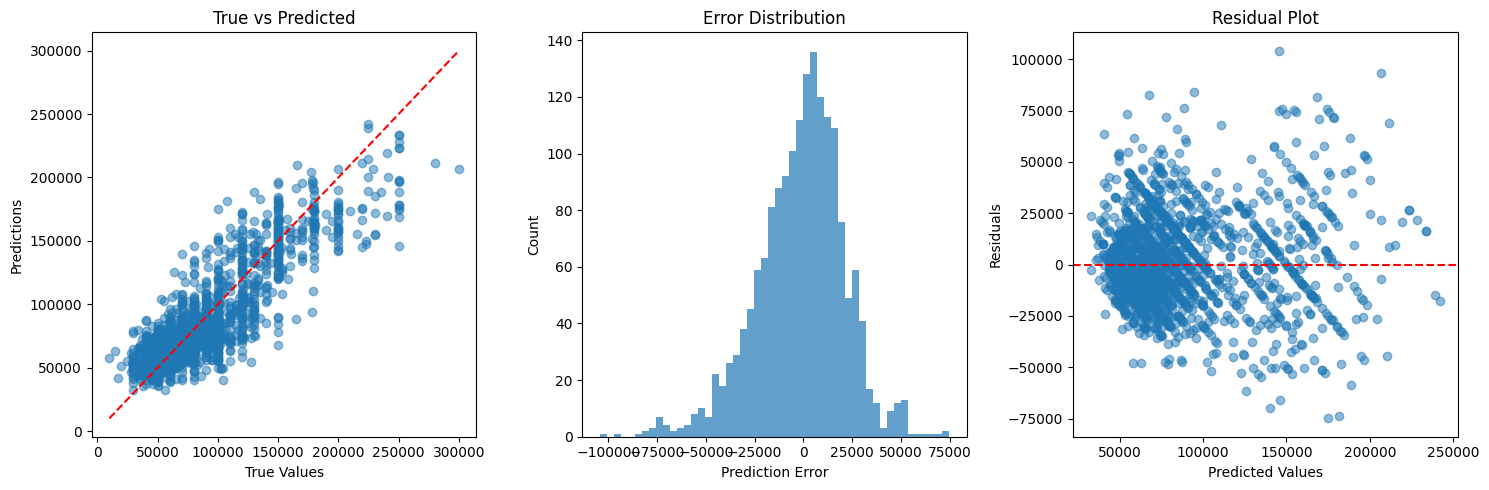

9. Анализ важности признаков...


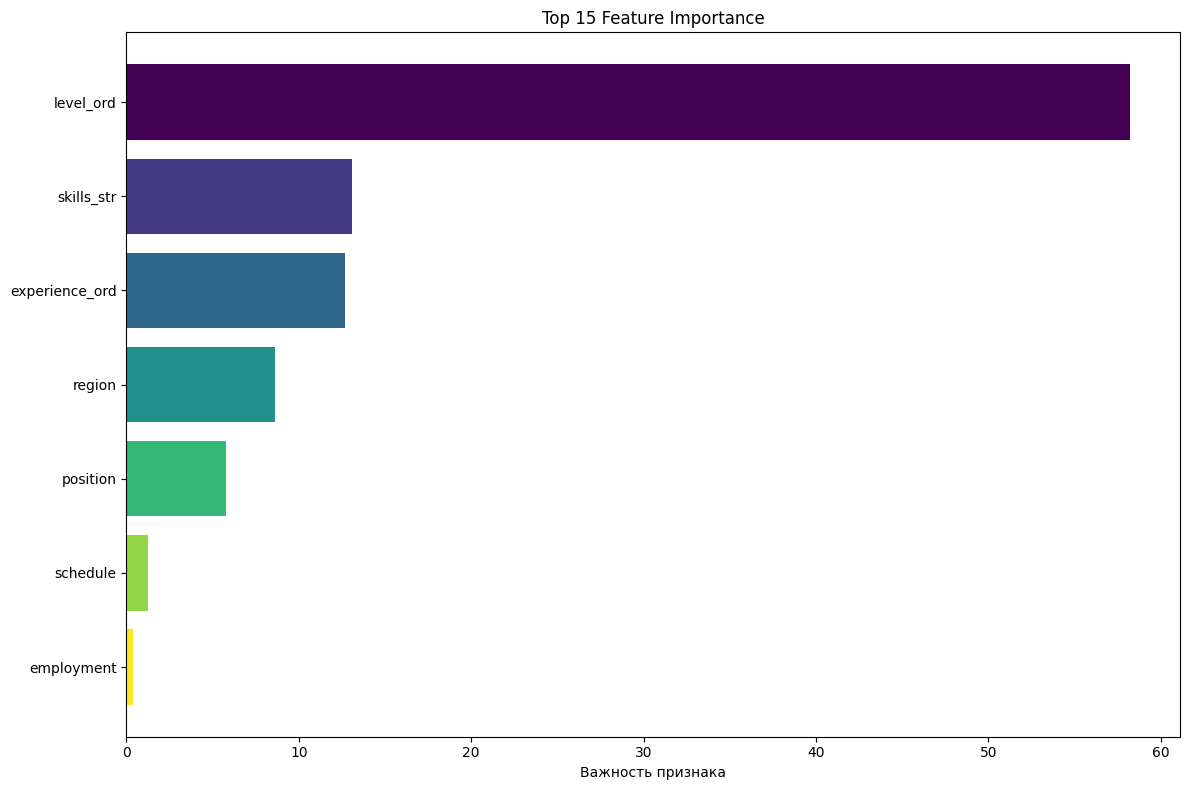

   Топ-10 важных признаков:
    5. level_ord           : 58.2094
    6. skills_str          : 13.1000
    2. experience_ord      : 12.6733
    7. region              : 8.5940
    1. position            : 5.7553
    3. schedule            : 1.2767
    4. employment          : 0.3913
   Важность признаков сохранена в feature_importance.csv
8. Сохранение модели и артефактов...
   Модель и артефакты сохранены!
✅ Финальный пайплайн завершен!
📊 Итоговые метрики:
   MAE: 17218.23
   R²: 0.7441
   MAPE: 0.2229
   Размер обучающей выборки: 8653
   Количество признаков: 7


In [17]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Параметры
top_skills = 30
top_vacancies = 5000

# Лучшие параметры из Optuna
best_params = {
    'iterations': 1404,
    'learning_rate': 0.14647974385325152,
    'depth': 9,
    'l2_leaf_reg': 1.7865444706705154,
    'random_strength': 0.8393042307586931,
    'bagging_temperature': 0.9454845290374145,
    'border_count': 104,
    'min_data_in_leaf': 10,
    'grow_policy': 'Lossguide',
    'task_type': 'GPU',
    'verbose': 100
}

best_params_no_vac = {'iterations': 1366, 'learning_rate': 0.029480499584883798, 'depth': 8, 'l2_leaf_reg': 9.306348992747079, 
 'random_strength': 9.269354649954655, 'bagging_temperature': 0.24923876946619955, 
 'border_count': 139, 'min_data_in_leaf': 42, 'grow_policy': 'Lossguide'}

# Список позиций, которые оставляем
allowed_positions = [
    "Аналитик",
    "Бизнес-аналитик",
    "Дизайнер, художник",
    "Продуктовый аналитик",
    "Руководитель проектов",
    "Сетевой инженер",
    "Системный администратор",
    "Специалист по информационной безопасности",
    "Специалист технической поддержки",
    "Технический писатель"
    #"Тестировщик",
    #"Программист, разработчик"
]

def prepare_final_data(df):
    """Подготовка финального датасета"""
    print("1. Фильтрация по топ-N скилов...")
    df_skills_filtered = filtered_skills_top_n(df.copy(), top_skills)
    df_skills_filtered = df_skills_filtered[df_skills_filtered['mapped_skills'].apply(lambda x: len(x) > 0)]
    
    print("2. Фильтрация по топ-N вакансий...")
    def filter_top_vacancies(group, n=top_vacancies):
        vac_counts = group['vacancy_clustered'].value_counts()
        top_vacancies = vac_counts.head(n).index.tolist()
        return group[group['vacancy_clustered'].isin(top_vacancies)]
    
    df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)
    df_filtered = df_filtered[df_filtered['position'].isin(allowed_positions)]
    
    print("3. Обработка целевой переменной...")
    df_temp = df_filtered.copy()
    
    # Очистка целевой переменной от выбросов
    positions_temp = df_temp['position'].dropna().unique()
    for pos in positions_temp:
        pos_mask = df_temp['position'] == pos
        clean_series = process_series(df_temp.loc[pos_mask, 'salary from'], 'salary from', pos)
        if clean_series is not None:
            df_temp.loc[clean_series.index, 'salary from norm'] = clean_series
    
    # Удалим строки с NaN после очистки
    df_temp = df_temp.dropna(subset=['salary from norm'])
    
    print(f"4. Финальный размер датасета: {df_temp.shape}")
    print(f"   Распределение по позициям:\n{df_temp['position'].value_counts()}")
    
    return df_temp

def create_features(df):
    """Создание финальных признаков"""
    # Порядковое кодирование
    experience_order = {
        'Нет опыта': 0,
        '1–3 года': 1,
        '3–6 лет': 2,
        'Более 6 лет': 3,
        'Unknown': -1
    }

    level_order = {
        'Trainee': 0,
        'Junior': 1,
        'Middle': 2,
        'Senior': 3,
        'Lead': 4,
        'Chief': 5,
        'Unknown': -1
    }
    
    df['experience_ord'] = df['experience'].map(experience_order).fillna(-1).astype(int)
    df['level_ord'] = df['level'].map(level_order).fillna(-1).astype(int)
    
    # Преобразование skills в строки
    df['skills_str'] = df['mapped_skills'].apply(
        lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x)
    )
    
    # Заполнение пропусков
    for col in ['schedule', 'employment', 'region']:
        df[col] = df[col].fillna('Unknown')
    
    features = ['position', 'experience_ord', 'schedule', 'employment', 'level_ord', 'skills_str', 'region'] # , 'vacancy_clustered'
    X = df[features]
    y = df['salary from norm']
    
    cat_features = ['position', 'experience_ord', 'schedule', 'employment', 'level_ord', 'region'] # , 'vacancy_clustered'
    text_features = ['skills_str']
    
    return X, y, cat_features, text_features

def train_final_model(X, y, cat_features, text_features):
    """Обучение финальной модели"""
    print("5. Разделение на train/test...")
    
    # Стратифицированное разделение
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in splitter.split(X, X['position']):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    print(f"   Train size: {X_train.shape[0]}")
    print(f"   Test size: {X_test.shape[0]}")
    
    # Создание Pool объектов
    train_pool = Pool(
        data=X_train,
        label=y_train,
        cat_features=cat_features,
        text_features=text_features
    )
    
    test_pool = Pool(
        data=X_test,
        label=y_test,
        cat_features=cat_features,
        text_features=text_features
    )
    
    print("6. Обучение финальной модели...")
    model = CatBoostRegressor(**best_params_no_vac) # best_params
    
    model.fit(
        train_pool,
        eval_set=test_pool,
        early_stopping_rounds=100,
        use_best_model=True
    )
    
    return model, X_test, y_test

def evaluate_model(model, X_test, y_test):
    """Оценка модели"""
    print("7. Оценка модели...")
    
    y_pred = model.predict(X_test)
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    print(f"   MAE: {mae:.2f}")
    print(f"   R²: {r2:.4f}")
    print(f"   MAPE: {mape:.4f}")
    
    # Визуализация предсказаний
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted')
    
    plt.subplot(1, 3, 2)
    errors = y_pred - y_test
    plt.hist(errors, bins=50, alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title('Error Distribution')
    
    plt.subplot(1, 3, 3)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    plt.tight_layout()
    plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return mae, r2, mape

def save_model_and_artifacts(model, X, cat_features, text_features):
    """Сохранение модели и артефактов"""
    print("8. Сохранение модели и артефактов...")
    
    # Сохранение модели
    model.save_model('final_catboost_model.cbm')
    
    # Сохранение информации о признаках
    feature_info = {
        'cat_features': cat_features,
        'text_features': text_features,
        'all_features': X.columns.tolist()
    }
    joblib.dump(feature_info, 'feature_info.pkl')
    
    # Сохранение лучших параметров
    pd.DataFrame([best_params]).to_csv('best_params.csv', index=False)
    
    print("   Модель и артефакты сохранены!")

def analyze_feature_importance(model, X):
    """Анализ важности признаков"""
    print("9. Анализ важности признаков...")
    
    try:
        # Получаем важность признаков
        feature_importance = model.get_feature_importance()
        feature_names = X.columns.tolist()
        
        # Проверяем, что размерности совпадают
        if len(feature_importance) != len(feature_names):
            print(f"   Размерности не совпадают: features={len(feature_names)}, importance={len(feature_importance)}")
            # Берем минимум из двух
            min_len = min(len(feature_names), len(feature_importance))
            feature_names = feature_names[:min_len]
            feature_importance = feature_importance[:min_len]
        
        # Создаем DataFrame с важностью признаков
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        # Фильтруем признаки с положительной важностью
        importance_df = importance_df[importance_df['importance'] > 0]
        
        if len(importance_df) == 0:
            print("   Все признаки имеют нулевую важность")
            return importance_df
        
        # Визуализация
        try:
            plt.figure(figsize=(12, 8))
            top_features = importance_df.head(15)
            
            # Простая визуализация без seaborn
            colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
            bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
            
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Важность признака')
            plt.title('Top 15 Feature Importance')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()
            
        except Exception as viz_error:
            print(f"   Ошибка визуализации: {viz_error}")
            print("   Продолжаем без визуализации...")
        
        print("   Топ-10 важных признаков:")
        for i, row in importance_df.head(10).iterrows():
            print(f"   {i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")
        
        # Сохраняем в CSV
        importance_df.to_csv('feature_importance.csv', index=False)
        print("   Важность признаков сохранена в feature_importance.csv")
        
        return importance_df
        
    except Exception as e:
        print(f"   Ошибка при анализе важности признаков: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

# Основной пайплайн
print("🚀 Запуск финального пайплайна обучения...")
print("=" * 50)

# 1. Подготовка данных
df_final = prepare_final_data(df_train_result.copy())

# 2. Создание признаков
X, y, cat_features, text_features = create_features(df_final)

# 3. Обучение модели
model, X_test, y_test = train_final_model(X, y, cat_features, text_features)

# 4. Оценка модели
mae, r2, mape = evaluate_model(model, X_test, y_test)

# 5. Анализ важности признаков
importance_df = analyze_feature_importance(model, X)

# 6. Сохранение результатов
save_model_and_artifacts(model, X, cat_features, text_features)

print("=" * 50)
print("✅ Финальный пайплайн завершен!")
print(f"📊 Итоговые метрики:")
print(f"   MAE: {mae:.2f}")
print(f"   R²: {r2:.4f}")
print(f"   MAPE: {mape:.4f}")
print(f"   Размер обучающей выборки: {X.shape[0]}")
print(f"   Количество признаков: {X.shape[1]}")

Без Vacancy

📊 Итоговые метрики:


   MAE: 16901.79


   R²: 0.7534


   MAPE: 0.2205


   Размер обучающей выборки: 8653
   Количество признаков: 7

30 vacancy

✅ Финальный пайплайн завершен!

📊 Итоговые метрики:
   MAE: 15539.31

   R²: 0.7704

   MAPE: 0.2044

   Размер обучающей выборки: 4131
   Количество признаков: 8

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Параметры
top_skills = 30
top_vacancies = 5000

# Лучшие параметры из Optuna
best_params = {
    'iterations': 1404,
    'learning_rate': 0.14647974385325152,
    'depth': 9,
    'l2_leaf_reg': 1.7865444706705154,
    'random_strength': 0.8393042307586931,
    'bagging_temperature': 0.9454845290374145,
    'border_count': 104,
    'min_data_in_leaf': 10,
    'grow_policy': 'Lossguide',
    'task_type': 'GPU',
    'verbose': 100
}

best_params_no_vac = {'iterations': 1366, 'learning_rate': 0.029480499584883798, 'depth': 8, 'l2_leaf_reg': 9.306348992747079, 
 'random_strength': 9.269354649954655, 'bagging_temperature': 0.24923876946619955, 
 'border_count': 139, 'min_data_in_leaf': 42, 'grow_policy': 'Lossguide'}

# Список позиций, которые оставляем
allowed_positions = [
    "Аналитик",
    "Бизнес-аналитик",
    "Дизайнер, художник",
    "Продуктовый аналитик",
    "Руководитель проектов",
    "Сетевой инженер",
    "Системный администратор",
    "Специалист по информационной безопасности",
    "Специалист технической поддержки",
    "Технический писатель"
    #"Тестировщик",
    #"Программист, разработчик"
]

def prepare_final_data(df):
    """Подготовка финального датасета"""
    print("1. Фильтрация по топ-N скилов...")
    df_skills_filtered = filtered_skills_top_n(df.copy(), top_skills)
    df_skills_filtered = df_skills_filtered[df_skills_filtered['mapped_skills'].apply(lambda x: len(x) > 0)]
    
    print("2. Фильтрация по топ-N вакансий...")
    def filter_top_vacancies(group, n=top_vacancies):
        vac_counts = group['vacancy_clustered'].value_counts()
        top_vacancies = vac_counts.head(n).index.tolist()
        return group[group['vacancy_clustered'].isin(top_vacancies)]
    
    df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)
    df_filtered = df_filtered[df_filtered['position'].isin(allowed_positions)]
    
    print("3. Обработка целевой переменной...")
    df_temp = df_filtered.copy()
    
    # Очистка целевой переменной от выбросов
    positions_temp = df_temp['position'].dropna().unique()
    for pos in positions_temp:
        pos_mask = df_temp['position'] == pos
        clean_series = process_series(df_temp.loc[pos_mask, 'salary to'], 'salary to', pos)
        if clean_series is not None:
            df_temp.loc[clean_series.index, 'salary to norm'] = clean_series
    
    # Удалим строки с NaN после очистки
    df_temp = df_temp.dropna(subset=['salary to norm'])
    
    print(f"4. Финальный размер датасета: {df_temp.shape}")
    print(f"   Распределение по позициям:\n{df_temp['position'].value_counts()}")
    
    return df_temp

def create_features(df):
    """Создание финальных признаков"""
    # Порядковое кодирование
    experience_order = {
        'Нет опыта': 0,
        '1–3 года': 1,
        '3–6 лет': 2,
        'Более 6 лет': 3,
        'Unknown': -1
    }

    level_order = {
        'Trainee': 0,
        'Junior': 1,
        'Middle': 2,
        'Senior': 3,
        'Lead': 4,
        'Chief': 5,
        'Unknown': -1
    }
    
    df['experience_ord'] = df['experience'].map(experience_order).fillna(-1).astype(int)
    df['level_ord'] = df['level'].map(level_order).fillna(-1).astype(int)
    
    # Преобразование skills в строки
    df['skills_str'] = df['mapped_skills'].apply(
        lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x)
    )
    
    # Заполнение пропусков
    for col in ['schedule', 'employment', 'region']:
        df[col] = df[col].fillna('Unknown')
    
    features = ['position', 'experience_ord', 'schedule', 'employment', 'level_ord', 'skills_str', 'region'] # , 'vacancy_clustered'
    X = df[features]
    y = df['salary to norm']
    
    cat_features = ['position', 'experience_ord', 'schedule', 'employment', 'level_ord', 'region'] # , 'vacancy_clustered'
    text_features = ['skills_str']
    
    return X, y, cat_features, text_features

def train_final_model(X, y, cat_features, text_features):
    """Обучение финальной модели"""
    print("5. Разделение на train/test...")
    
    # Стратифицированное разделение
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in splitter.split(X, X['position']):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    print(f"   Train size: {X_train.shape[0]}")
    print(f"   Test size: {X_test.shape[0]}")
    
    # Создание Pool объектов
    train_pool = Pool(
        data=X_train,
        label=y_train,
        cat_features=cat_features,
        text_features=text_features
    )
    
    test_pool = Pool(
        data=X_test,
        label=y_test,
        cat_features=cat_features,
        text_features=text_features
    )
    
    print("6. Обучение финальной модели...")
    model = CatBoostRegressor(**best_params_no_vac) # best_params
    
    model.fit(
        train_pool,
        eval_set=test_pool,
        early_stopping_rounds=100,
        use_best_model=True
    )
    
    return model, X_test, y_test

def evaluate_model(model, X_test, y_test):
    """Оценка модели"""
    print("7. Оценка модели...")
    
    y_pred = model.predict(X_test)
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    print(f"   MAE: {mae:.2f}")
    print(f"   R²: {r2:.4f}")
    print(f"   MAPE: {mape:.4f}")
    
    # Визуализация предсказаний
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted')
    
    plt.subplot(1, 3, 2)
    errors = y_pred - y_test
    plt.hist(errors, bins=50, alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title('Error Distribution')
    
    plt.subplot(1, 3, 3)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    plt.tight_layout()
    plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return mae, r2, mape

def save_model_and_artifacts(model, X, cat_features, text_features):
    """Сохранение модели и артефактов"""
    print("8. Сохранение модели и артефактов...")
    
    # Сохранение модели
    model.save_model('final_catboost_model.cbm')
    
    # Сохранение информации о признаках
    feature_info = {
        'cat_features': cat_features,
        'text_features': text_features,
        'all_features': X.columns.tolist()
    }
    joblib.dump(feature_info, 'feature_info.pkl')
    
    # Сохранение лучших параметров
    pd.DataFrame([best_params]).to_csv('best_params.csv', index=False)
    
    print("   Модель и артефакты сохранены!")

def analyze_feature_importance(model, X):
    """Анализ важности признаков"""
    print("9. Анализ важности признаков...")
    
    try:
        # Получаем важность признаков
        feature_importance = model.get_feature_importance()
        feature_names = X.columns.tolist()
        
        # Проверяем, что размерности совпадают
        if len(feature_importance) != len(feature_names):
            print(f"   Размерности не совпадают: features={len(feature_names)}, importance={len(feature_importance)}")
            # Берем минимум из двух
            min_len = min(len(feature_names), len(feature_importance))
            feature_names = feature_names[:min_len]
            feature_importance = feature_importance[:min_len]
        
        # Создаем DataFrame с важностью признаков
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        # Фильтруем признаки с положительной важностью
        importance_df = importance_df[importance_df['importance'] > 0]
        
        if len(importance_df) == 0:
            print("   Все признаки имеют нулевую важность")
            return importance_df
        
        # Визуализация
        try:
            plt.figure(figsize=(12, 8))
            top_features = importance_df.head(15)
            
            # Простая визуализация без seaborn
            colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
            bars = plt.barh(range(len(top_features)), top_features['importance'], color=colors)
            
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Важность признака')
            plt.title('Top 15 Feature Importance')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()
            
        except Exception as viz_error:
            print(f"   Ошибка визуализации: {viz_error}")
            print("   Продолжаем без визуализации...")
        
        print("   Топ-10 важных признаков:")
        for i, row in importance_df.head(10).iterrows():
            print(f"   {i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")
        
        # Сохраняем в CSV
        importance_df.to_csv('feature_importance.csv', index=False)
        print("   Важность признаков сохранена в feature_importance.csv")
        
        return importance_df
        
    except Exception as e:
        print(f"   Ошибка при анализе важности признаков: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

# Основной пайплайн
print("🚀 Запуск финального пайплайна обучения...")
print("=" * 50)

# 1. Подготовка данных
df_final = prepare_final_data(df_train_result.copy())

# 2. Создание признаков
X, y, cat_features, text_features = create_features(df_final)

# 3. Обучение модели
model, X_test, y_test = train_final_model(X, y, cat_features, text_features)

# 4. Оценка модели
mae, r2, mape = evaluate_model(model, X_test, y_test)

# 5. Анализ важности признаков
importance_df = analyze_feature_importance(model, X)

# 6. Сохранение результатов
save_model_and_artifacts(model, X, cat_features, text_features)

print("=" * 50)
print("✅ Финальный пайплайн завершен!")
print(f"📊 Итоговые метрики:")
print(f"   MAE: {mae:.2f}")
print(f"   R²: {r2:.4f}")
print(f"   MAPE: {mape:.4f}")
print(f"   Размер обучающей выборки: {X.shape[0]}")
print(f"   Количество признаков: {X.shape[1]}")

Топ-10 важных признаков:
5. level_ord           : 50.8892
6. skills_str          : 18.7869
1. position            : 10.1557
2. experience_ord      : 9.8037
7. region              : 9.1756
3. schedule            : 0.9742
4. employment          : 0.2147
Важность признаков сохранена в feature_importance.csv


==================================================


✅ Финальный пайплайн завершен!

📊 Итоговые метрики:

   MAE: 21367.33

   R²: 0.6847

   MAPE: 0.2525

   Размер обучающей выборки: 8582
   
   Количество признаков: 7